In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/과제1/Modeling')

In [6]:
pwd

'/content/drive/MyDrive/과제1/Modeling'

In [11]:
df = pd.read_csv(r'../dataset/preprocessed.csv')
df

,chest,arm,height,waist,crotch,head,foot,weight
0,96.3,92.6,185.5,82.5,83.8,57.1,28.5,73.2
1,101.9,83.8,167.2,81.2,74.4,55.0,24.2,65.1
2,99.5,89.6,179.9,99.2,84.2,56.3,28.1,93.2
3,98.6,85.5,171.4,85.9,76.4,54.5,27.4,71.6
4,94.7,88.1,176.9,78.3,79.7,58.5,26.5,67.1
...,...,...,...,...,...,...,...,...
167974,100.6,86.4,173.2,86.7,77.1,56.9,27.1,73.7
167975,97.9,82.7,166.3,90.5,73.4,61.5,28.8,70.7
167976,97.9,87.2,175.2,94.3,83.1,57.1,27.6,78.7
167977,85.3,86.8,173.6,75.9,76.6,57.6,24.3,57.4


In [12]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.X = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]
    def __len__(self):
        return len(self.X)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['height','weight'],axis=1)
y = df[['height','weight']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [14]:
train_dataset = MyDataset(train_scaled, y_train)
test_dataset = MyDataset(test_scaled, y_test)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [63]:
model = nn.Sequential(
    nn.Linear(6, 128),
    nn.Sigmoid(),
    nn.Linear(128, 64),
    nn.Sigmoid(),
    nn.Linear(64, 32),
     nn.Sigmoid(),
    nn.Linear(32, 2)
)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [64]:
from tqdm import tqdm
def train_loop(dataloader, model, loss_fn, optimizer):
    model.to('cuda')
    t_bar = tqdm(dataloader)
    losses = 0
    for X, y in t_bar:
        X = X.to('cuda')
        y = y.to('cuda')
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        t_bar.set_description(f" MAE loss: {pow(loss,0.5):.2f}")
        losses += loss.item()
    return pow(losses / len(dataloader),0.5)
def valid_loop(dataloader, model, loss_fn):
    losses = 0
    with torch.no_grad():
      for X, y in dataloader:
          X = X.to('cuda')
          y = y.to('cuda')
          pred = model(X)
          losses += loss_fn(pred, y).item()
    print(f"Validation MAE loss: {pow(losses / len(dataloader),0.5):.2f}")
    return pow(losses / len(dataloader),0.5)

In [65]:
train_histtory = []
valid_history = []

In [66]:
epochs = 10
for e in range(epochs):
    print(f"Epoch {e+1}")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    valid_loss = valid_loop(test_loader, model, loss_fn)
    train_histtory.append(train_loss)
    valid_history.append(valid_loss)

Epoch 1


 MAE loss: 43.24: 100%|██████████| 4200/4200 [00:16<00:00, 252.92it/s]


Validation MAE loss: 43.98
Epoch 2


 MAE loss: 12.97: 100%|██████████| 4200/4200 [00:16<00:00, 254.70it/s]


Validation MAE loss: 10.50
Epoch 3


 MAE loss: 7.47: 100%|██████████| 4200/4200 [00:16<00:00, 253.10it/s]


Validation MAE loss: 7.17
Epoch 4


 MAE loss: 4.37: 100%|██████████| 4200/4200 [00:16<00:00, 252.60it/s]


Validation MAE loss: 3.84
Epoch 5


 MAE loss: 2.19: 100%|██████████| 4200/4200 [00:16<00:00, 256.21it/s]


Validation MAE loss: 3.43
Epoch 6


 MAE loss: 3.59: 100%|██████████| 4200/4200 [00:16<00:00, 255.51it/s]


Validation MAE loss: 3.34
Epoch 7


 MAE loss: 1.91: 100%|██████████| 4200/4200 [00:16<00:00, 255.20it/s]


Validation MAE loss: 3.32
Epoch 8


 MAE loss: 2.28: 100%|██████████| 4200/4200 [00:16<00:00, 254.02it/s]


Validation MAE loss: 3.29
Epoch 9


 MAE loss: 2.72: 100%|██████████| 4200/4200 [00:16<00:00, 253.97it/s]


Validation MAE loss: 3.30
Epoch 10


 MAE loss: 3.77: 100%|██████████| 4200/4200 [00:16<00:00, 256.63it/s]


Validation MAE loss: 3.28


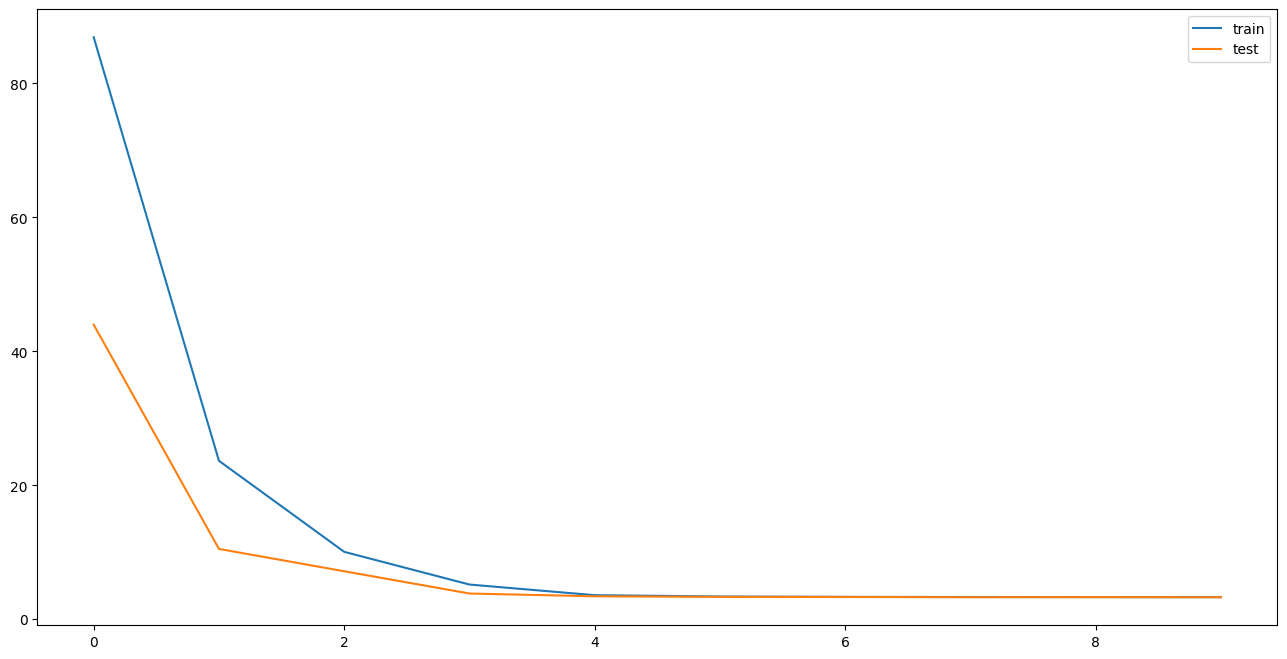

In [67]:
f,a = plt.subplots(1,1,figsize = (16,8))
a.plot(train_histtory,label = 'train')
a.plot(valid_history,label = 'test')
a.legend()


In [68]:
train_histtory

[86.8943907330902,
 23.65782149129161,
 10.066296492565646,
 5.182318405118901,
 3.5927560251489696,
 3.394969856697357,
 3.343121146736512,
 3.319971814677466,
 3.309732012083789,
 3.3011479572853273]

In [ ]:
# 데이터 많아서 오버피팅도 안된다